# RTMA Parallel Ingestion

This notebook demonstrates parallel ingestion of RTMA weather data from AWS Open Data into Arraylake using Coiled for distributed processing.

## Dataset Caveats

1. **Missing Days**: Some days have incomplete data (fewer than 24 hourly files). We leave gaps in the time series.

2. **Changing Domain**: Different file extensions indicate different spatial domains:
   - `.grb2` - base domain
   - `.grb2_ext` - extended to the north
   - `.grb2_wexp` - extended towards the west
   
   Solution: Pad smaller domains to the largest common grid size.

## Configuration

In [1]:
import warnings
from distributed import WorkerPlugin

# Filter by the specific category and a snippet of the message
warnings.filterwarnings("ignore", category=FutureWarning, message=".*In a future version of xarray.*")

# Implement the same filter as a Dask worker plugin
class SuppressWarnings(WorkerPlugin):
    def setup(self, worker):
        import warnings
        warnings.filterwarnings("ignore", message=".*compat.*will change.*", category=FutureWarning)

In [2]:
# Configuration variables

# Source information
SOURCE_BUCKET = "noaa-rtma-pds"
PRODUCT = "rtma2p5"    # Product and domain id. This could be swapped to read e.g. 
                            #the rapid update data or other regions
                            # ⚠️ This might require changes in the variables and logic!

# Restrict types and variables

# Product types to ingest
# PRODUCT_TYPES = ["anl", "ges", "err"]  # analysis, guess/forecast, error
# use only "anl" for MVP
PRODUCT_TYPES = ["anl"]
PRODUCT_TYPES_MAPPING = {
    "anl": "2dvaranl_ndfd",
    "ges": "2dvarges_ndfd",
    "err": "2dvarerr_ndfd",
}

# Chunking configuration
CHUNKS = {
    "time": 1,
    "y": 400,
    "x": 600,
}

## Helper Functions

In [3]:
import os
import re
import tempfile
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import date, datetime
from typing import Dict, List, Optional, Set, Tuple, Union

import arraylake as al
import cfgrib
import dask
import icechunk as ic
from icechunk.xarray import to_icechunk
import numpy as np
import obstore as obs
import xarray as xr
from obstore.store import S3Store
from zarr.errors import GroupNotFoundError

def discover_rtma_files(
    product_type: str,
    years: range = range(2016, 2025),
    months: range = range(1, 13),
    days: range = range(1, 32),
    region: str = "us-east-1",
    source_bucket: str = "noaa-rtma-pds",
    max_workers: int = 32
) -> Tuple[List[str], Dict[str, List[int]]]:
    """
    Discover all RTMA files for a given year and product type.
    
    Returns:
        (matched_urls, incomplete_days): 
            - List of matched S3 URLs
            - Dict mapping day_prefix -> list of missing hours (empty if day has all 24)
    """
    suffix = PRODUCT_TYPES_MAPPING[product_type]
    store = S3Store.from_url(f"s3://{source_bucket}", region=region, skip_signature=True)
    
    # Build list of valid target days (e.g., "rtma2p5.20160115")
    target_days: Set[str] = set()
    for year in years:
        for month in months:
            for day in days:
                try:
                    date(year, month, day)  # Validate it's a real date
                    target_days.add(f"rtma2p5.{year}{month:02d}{day:02d}")
                except ValueError:
                    pass  # Skip invalid dates like Feb 30
    
    # Pattern: rtma2p5.t{HH}z.{suffix}.grb2 (with possible extra extensions)
    file_pattern = re.compile(rf"rtma2p5\.t(\d{{2}})z\.{re.escape(suffix)}\.grb2")
    
    def scan_day(day_prefix: str) -> Dict[int, str]:
        """Scan a single day and return {hour: url} dict."""
        day_files = {}
        store = S3Store.from_url(f"s3://{source_bucket}", region=region, skip_signature=True)
        
        for list_result in obs.list(store, prefix=day_prefix):
            for item in list_result:
                path = item["path"]
                filename = path.split("/")[-1]
                
                if filename.endswith(".idx"):
                    continue
                
                match = file_pattern.match(filename)
                if match:
                    hour = int(match.group(1))
                    full_url = f"s3://{source_bucket}/{path}"
                    if hour not in day_files:
                        day_files[hour] = full_url
        
        return day_files
    
    # Scan all days in parallel
    files_by_day: Dict[str, Dict[int, str]] = {}
    sorted_days = sorted(target_days)
    total_days = len(sorted_days)
    
    print(f"Scanning {total_days} days with {max_workers} workers...")
    
    completed = 0
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_day = {executor.submit(scan_day, day): day for day in sorted_days}
        
        for future in as_completed(future_to_day):
            day_prefix = future_to_day[future]
            completed += 1
            
            if completed % 100 == 0 or completed == total_days:
                print(f"  Progress: {completed}/{total_days} days")
            
            try:
                day_files = future.result()
                if day_files:
                    files_by_day[day_prefix] = day_files
            except Exception as e:
                print(f"  Error scanning {day_prefix}: {e}")
    
    # Collect all matched URLs (sorted by day and hour)
    matched_urls: List[str] = []
    for day_prefix in sorted(files_by_day.keys()):
        for hour in sorted(files_by_day[day_prefix].keys()):
            matched_urls.append(files_by_day[day_prefix][hour])
    
    print(f"Scanned {total_days} days, found {len(matched_urls)} files")
    
    # Identify incomplete days (fewer than 24 hours)
    all_hours = set(range(24))
    incomplete_days: Dict[str, List[int]] = {}
    
    for day_prefix in target_days:
        found_hours = set(files_by_day.get(day_prefix, {}).keys())
        missing_hours = sorted(all_hours - found_hours)
        if missing_hours:  # Only report if something is missing
            incomplete_days[day_prefix] = missing_hours

    matched_urls = sorted(matched_urls)
    
    return matched_urls, incomplete_days


def print_report(matched_urls: List[str], incomplete_days: Dict[str, List[int]]) -> None:
    """Print a summary report of the discovery results."""
    print("\n" + "=" * 60)
    print("RTMA FILE DISCOVERY REPORT")
    print("=" * 60)
    print(f"\nTotal files found: {len(matched_urls)}")
    
    complete_days = (len(matched_urls) // 24) if matched_urls else 0
    print(f"Complete days (24 files): ~{complete_days}")
    
    if incomplete_days:
        # Separate completely missing vs partially missing
        fully_missing = {d: h for d, h in incomplete_days.items() if len(h) == 24}
        partial = {d: h for d, h in incomplete_days.items() if len(h) < 24}
        
        if fully_missing:
            print(f"\nFully missing days ({len(fully_missing)}):")
            for day in sorted(fully_missing.keys()):
                print(f"  - {day}")
        
        if partial:
            print(f"\nPartially missing days ({len(partial)}):")
            for day in sorted(partial.keys()):
                missing = partial[day]
                hours_str = ", ".join(f"{h:02d}" for h in missing)
                print(f"  - {day}: missing hours [{hours_str}]")
    else:
        print("\nAll days complete with 24 hourly files!")
    
    if matched_urls:
        print(f"\nFirst file: {matched_urls[0]}")
        print(f"Last file:  {matched_urls[-1]}")

def download_grib_file(url: str, local_path: str, region: str = "us-east-1") -> None:
    """Download a GRIB file from S3 to local storage."""
    
    match = re.match(r"s3://([^/]+)/(.+)", url)
    bucket, path = match.groups()
    
    store = S3Store.from_url(f"s3://{bucket}", region=region, skip_signature=True)
    result = obs.get(store, path)
    
    os.makedirs(os.path.dirname(local_path), exist_ok=True)
    
    with open(local_path, "wb") as f:
        f.write(result.bytes())

def build_rtma_path(year:int, month:int, day:int, hour: int, product_type: str) -> str:
    """Build S3 path for an RTMA 2.5km file."""
    suffix = PRODUCT_TYPES_MAPPING[product_type]
    return f"s3://{SOURCE_BUCKET}/rtma2p5.{year}{month:02d}{day:02d}/rtma2p5.t{hour:02d}z.{suffix}.grb2"

import pandas as pd
def url2datetime(url:str) -> datetime:
    pattern = r'rtma2p5\.(\d{4})(\d{2})(\d{2})/rtma2p5\.t(\d{2})z'
    match = re.search(pattern, url)
    dt = pd.Timestamp(*map(int, match.groups())) #converts matched groups to int before passing
    return dt

def postprocess(ds:xr.Dataset) -> xr.Dataset:
    for dim in ['time', 'step']:
        ds = ds.expand_dims(dim)
    valid_time = xr.DataArray([ds.valid_time.values], dims=['time'])
    ds = ds.drop('valid_time')
    # set height as attr on each variable and drop (TODO: revisit if this is the best approach)
    scalar_dims = ['heightAboveGround']
    for sd in scalar_dims:
        for var in ds.data_vars:
            ds[var].attrs[sd] = ds.coords[sd].values.tolist()
        ds = ds.reset_coords(sd, drop=True)
    
    # X axis / Longitude
    ds.longitude.attrs = {
        'axis': 'X',
        'standard_name': 'longitude',
        'units': 'degrees_east'
    }
    
    # Y axis / Latitude
    ds.latitude.attrs = {
        'axis': 'Y',
        'standard_name': 'latitude',
        'units': 'degrees_north'
    }
    return ds

def process_file(url:str) -> xr.Dataset:
    with tempfile.TemporaryDirectory() as tmpdir:
        local_path = os.path.join(tmpdir,url.split('://')[1])
        download_grib_file(url, local_path)
        datasets = cfgrib.open_datasets(local_path)
        # extract the wind variable message only for now
        [ds] = [ds for ds in datasets if 'u10' in ds.data_vars]
        ds = ds.load()
    ds = postprocess(ds)
    
    # pad all domains to the common (largest) grid
    x_padding = {'x':[200,0]}
    y_padding = {'y':[0,220]}
    pad_value = np.nan

    if url.endswith('.grb2'):
        ds = ds.pad(x_padding|y_padding, constant_values=pad_value)
    elif url.endswith('.grb2_ext'):
        ds = ds.pad(x_padding, constant_values=pad_value)
        
    ds = ds.chunk(CHUNKS)
    return ds


def build_skeleton_array(urls:List[str]):
    """build a lazy array that has the properties of a loaded file to build the metadata skeleton"""
    # load last url into a dataset to use as example (this needs to be the largest domain and match the padding rules 👆)
    ds_blueprint = process_file(urls[-1])
    
    # build time array (ensures that we do not build time for missing files (i confirmed a few cases!)    
    time_raw = [url2datetime(url) for url in urls]
    time = xr.DataArray([1 for i in range(len(time_raw))], dims=['time'], coords={'time':time_raw})
    time = time.chunk({'time':1})
    

    # broadcast to the right time shape
    ds_blueprint = ds_blueprint.broadcast_like(time)

    # load coordinates for quicker loading
    for co in ['longitude', 'latitude', 'time']:
        ds_blueprint.coords[co] = ds_blueprint.coords[co].load()
    return ds_blueprint

# See https://icechunk.io/en/latest/parallel/#distributed-writes
@dask.delayed
def write_timestep(
    url: str,
    session: ic.ForkSession,
    group: Optional[str]=None
) -> ic.ForkSession:
    ds = process_file(url)
    # remove all coordinates but time and step to avoid chunk conflicts (really just injecting the array data into regions here)
    ds = ds.reset_coords([co for co in ds.coords if co not in ['step', 'time']], drop=True)
    # Deepak said use this instead? I do not really understand what is happening here
    to_icechunk(ds, session, group=group, region='auto')
    # ds.to_zarr(session.store, region='auto', consolidated=False, group=group)
    return session

## File Discovery

In [4]:
# Full dataset
pt = PRODUCT_TYPES[0]
urls, incomplete = discover_rtma_files(
    pt, 
    years=range(2025, 2026), 
    months=range(1, 4), 
    days=range(1, 32)
)
    
print_report(urls, incomplete) # if you care about the missing days!

Scanning 90 days with 32 workers...
  Progress: 90/90 days
Scanned 90 days, found 2160 files

RTMA FILE DISCOVERY REPORT

Total files found: 2160
Complete days (24 files): ~90

All days complete with 24 hourly files!

First file: s3://noaa-rtma-pds/rtma2p5.20250101/rtma2p5.t00z.2dvaranl_ndfd.grb2_wexp
Last file:  s3://noaa-rtma-pds/rtma2p5.20250331/rtma2p5.t23z.2dvaranl_ndfd.grb2_wexp


## Initialize Storage

In [5]:
group = 'test-ingestion-cooperative-write'

client = al.Client()
client.login()
repo = client.get_repo('earthmover/rtma')
session = repo.writable_session('main')

╭───────────────────────────────── Login ─────────────────────────────────╮                    
                    │                                                                         │                    
                    │          Copy and paste the following ]8;id=703885;https://earthmover-production.us.auth0.com/activate?user_code=PMCP-XRCQ\link]8;;\ into your browser:           │                    
                    │                                                                         │                    
                    │ https://earthmover-production.us.auth0.com/activate?user_code=PMCP-XRCQ │                    
                    │                                                                         │                    
                    │                Ensure the code in your browser matches:                 │                    
                    │                              ╭───────────╮                              │                    
                    │                              │ PMCP-XRCQ │                              │                    
                    │                              ╰───────────╯                              │                    
                    │                                                                         │                    
                    │         Then follow the instructions in your browser to login.          │                    
                    │                   Visit ]8;id=157053;https://docs.earthmover.io/setup/org-access#authenticating-as-a-user\docs.earthmover.io]8;;\ for help.                    │                    
                    │                                                                         │                    
                    ╰─────────────────────────────────────────────────────────────────────────╯

Output()

Successfully logged in! Token stored at /home/cloudenv/.arraylake/token.json

╭───────────────────────────────────────────────── User Details ──────────────────────────────────────────────────╮
│ Name: Julius Busecke                                                                                            │
│ Email: julius@earthmover.io                                                                                     │
│ Id: 0d7588a7-a03e-4d1a-b862-fb8c52c95fab                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [6]:
# create a skeleton xr.dataset of the data so we can write out the full array metadata before inserting
# timesteps in parallel
ds_skeleton = build_skeleton_array(urls)

# write the skeletion
encoding = {k: {"chunks": CHUNKS} for k in ds_skeleton.data_vars}
ds_skeleton.to_zarr(session.store, consolidated=False, compute=False, encoding=encoding, group=group, mode='w') 
session.commit('resetting the array')

/tmp/ipykernel_741/4291449375.py:187: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = ds.drop('valid_time')


'5XQ8XZ6CWNH98P27DFB0'

In [7]:
ds_skeleton.nbytes/1e9

161.842424728

## Parallel Ingestion

In [8]:
session = repo.writable_session('main')
tasks = []
for url in urls:
    fork = session.fork()
    partial_session = write_timestep(url=url, session=fork, group=group)
    tasks.append(partial_session)

import coiled
cluster = coiled.Cluster(n_workers=50, worker_cpu=2, worker_memory="4GB", scheduler_memory="64GB", region='us-east-1')
client = cluster.get_client()

client.register_plugin(SuppressWarnings())
display(client)

futures = client.compute(tasks)
results = client.gather(futures)

Output()

<Client: 'tls://10.0.198.81:8786' processes=49 threads=98, memory=147.50 GiB>

In [9]:
# manually merge the remote sessions in to the local session
session.merge(*results)
print(session.commit("finished writes"))

8C31TXJH185HY3YJA580


## Verification

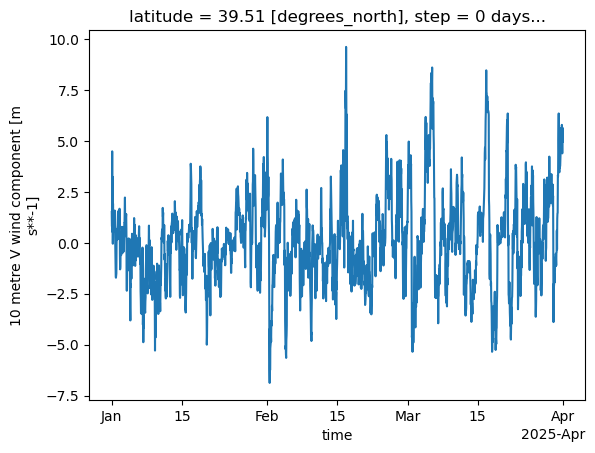

In [10]:
# check the write:
session = repo.readonly_session('main')
ds_test = xr.open_zarr(session.store, group=group)
ds_test.isel(x=2000, y=800).v10.plot()

In [11]:
ds_test.nbytes/1e9

161.842424728

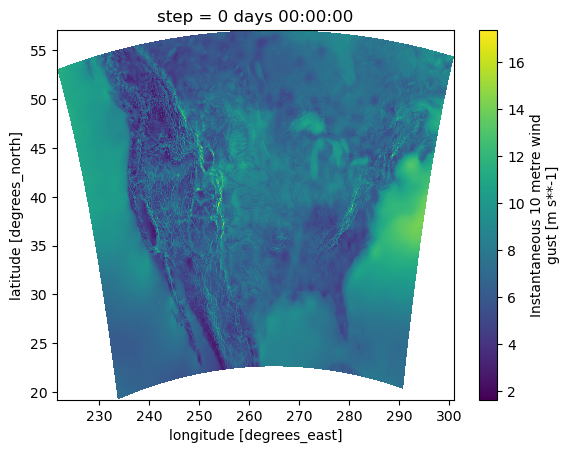

In [12]:
# check the write:
ds_test = xr.open_zarr(session.store, group=group)
ds_test.i10fg.mean('time').plot(x='longitude', y='latitude')